![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

In [12]:
# Some stuff to get us going:
!pip install invertedai
import sys
from IPython.display import clear_output
clear_output()

In [13]:
from IPython.display import display, Image, clear_output
import invertedai as iai
from invertedai.common import AgentType
from invertedai import get_regions_default
from invertedai.utils import get_default_agent_properties

import numpy as np
import matplotlib.pyplot as plt

from typing import List
clear_output()

# Provide your API key

In [14]:
iai.add_apikey("")

# Setup

Set up the simulation by defining the location, simulation length (1 step = 0.1 second), and some other constants.

In [15]:
print("Begin initialization.")
LOCATION = "canada:drake_street_and_pacific_blvd"

NUM_EGO_AGENTS = 1
NUM_NPC_AGENTS = 10
NUM_TIME_STEPS = 100

RENDERING_FOV = 130
FIGURE_SIZE = 10
GIF_RATIO = 1.33
GIF_SIZE = 100*FIGURE_SIZE

Begin initialization.


# Preview the map location

(None, <matplotlib.image.AxesImage at 0x776a744c8f70>)

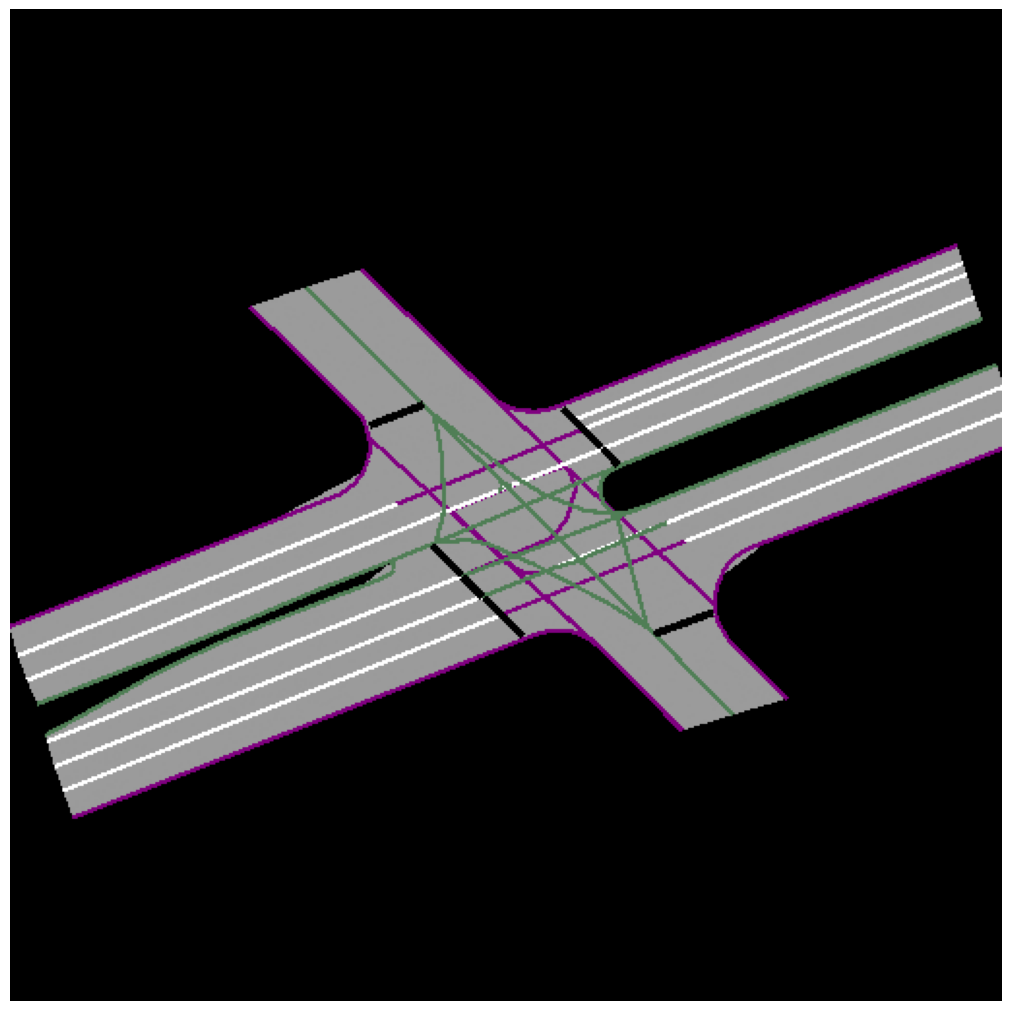

In [16]:
location_info = iai.location_info(location=LOCATION,rendering_fov=RENDERING_FOV)
rendered_map = location_info.birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

In [17]:
# Initialize the ScenePlotter for scene visualization
location_info_response = iai.location_info(location=LOCATION)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(
    rendered_static_map,
    location_info_response.map_fov,
    (location_info_response.map_center.x, location_info_response.map_center.y),
    location_info_response.static_actors
)

# Initialize the simulation

In [18]:
##########################################################################################################
# INSERT YOUR OWN EGO PREDICTIONS FOR THE INITIALIZATION
ego_response = iai.initialize(
    location = LOCATION,
    agent_properties = get_default_agent_properties({AgentType.car:NUM_EGO_AGENTS}),
)
ego_agent_properties = ego_response.agent_properties  # get dimension and other attributes of NPCs
##########################################################################################################

In [19]:
# Generate the region objects for large_initialization
regions = get_regions_default(
    location = LOCATION,
    agent_count_dict = {AgentType.car: NUM_NPC_AGENTS}
)
# Instantiate a stateful wrapper for Inverted AI API
iai_simulation = iai.BasicCosimulation(  
    location = LOCATION,
    ego_agent_properties = ego_agent_properties,
    ego_agent_agent_states = ego_response.agent_states,
    regions = regions,
    traffic_light_state_history = [ego_response.traffic_lights_states]
)
scene_plotter.initialize_recording(
    agent_states = iai_simulation.agent_states,
    agent_properties = iai_simulation.agent_properties,
    conditional_agents = list(range(NUM_EGO_AGENTS)),
    traffic_light_states = ego_response.traffic_lights_states
)

Initializing regions:   0%|          | 0/1 [00:00<?, ?it/s]

# Start the simulation

In [20]:
print("Begin stepping through simulation.")
times = []
for _ in range(NUM_TIME_STEPS):  # How many simulation time steps to execute (10 steps is 1 second)
##########################################################################################################    
    # INSERT YOUR OWN EGO PREDICTIONS FOR THIS TIME STEP
    ego_response = iai.drive(
        location = LOCATION,
        agent_properties = ego_agent_properties+iai_simulation.npc_properties,
        agent_states = ego_response.agent_states+iai_simulation.npc_states,
        recurrent_states = ego_response.recurrent_states+iai_simulation.npc_recurrent_states,
        light_recurrent_states = ego_response.light_recurrent_states,
    )
    ego_response.agent_states = ego_response.agent_states[:NUM_EGO_AGENTS]
    ego_response.recurrent_states = ego_response.recurrent_states[:NUM_EGO_AGENTS]
##########################################################################################################

    # Query the API for subsequent NPC predictions, informing it how the ego vehicle acted
    iai_simulation.step(
        current_ego_agent_states = ego_response.agent_states,
        traffic_lights_states = ego_response.traffic_lights_states
    )

    # Save the visualization with ScenePlotter
    scene_plotter.record_step(iai_simulation.agent_states,iai_simulation.light_states)
    
clear_output(wait=True)
print(f"Done stepping through simulation.")

Done stepping through simulation.


In [21]:
%%capture
# Save the visualization to disk
print("Simulation finished, save visualization.")
fig, ax = plt.subplots(constrained_layout=True, figsize=(50, 50))
plt.axis('off')
gif_name = 'cosimulation_minimal_example.gif'
scene_plotter.animate_scene(
    output_name = gif_name,
    ax = ax,
    direction_vec = False,
    velocity_vec = False,
    plot_frame_number = True
)
print("Done simulation")

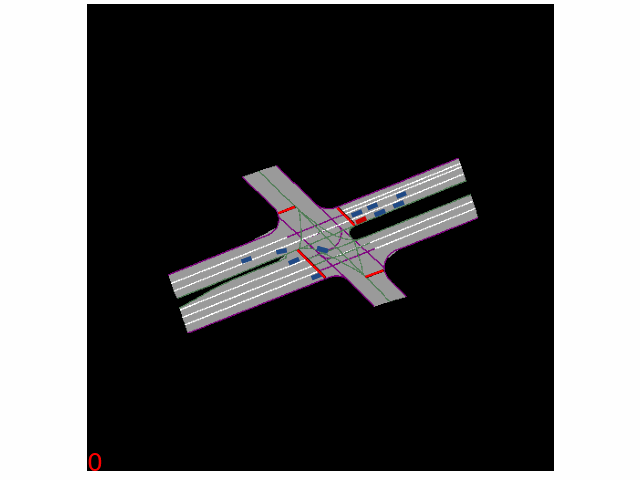

In [22]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)